# Árboles de decisión Regresión

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

## 3. Carga del dataset

In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/01_carDetailsV4_Prep.csv')

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1441 non-null   float64
 1   Year                1441 non-null   float64
 2   Kilometer           1441 non-null   float64
 3   Engine              1441 non-null   float64
 4   Length              1441 non-null   float64
 5   Width               1441 non-null   float64
 6   Height              1441 non-null   float64
 7   Seating Capacity    1441 non-null   float64
 8   Fuel Tank Capacity  1441 non-null   float64
 9   Fuel Type           1441 non-null   object 
 10  Transmission        1441 non-null   object 
 11  Owner               1441 non-null   object 
 12  Seller Type         1441 non-null   object 
 13  Drivetrain          1441 non-null   object 
 14  PriceRange          1441 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 169.0+

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,Fuel Type,Transmission,Owner,Seller Type,Drivetrain
0,Petrol,Automatic,First,Individual,FWD
1,Diesel,Automatic,First,Corporate,AWD


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head(2)

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,9540.0,2021.0,9000.0,1199.0,3993.0,1677.0,1532.0,5.0,35.0,1
1,10500.0,2014.0,99000.0,2199.0,4690.0,1880.0,1690.0,7.0,64.0,1


In [9]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [10]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
#multiple_plot(3, d , catCols, 'Price', 'boxplot', 'Distribución de la variable Make vs. el Price',30)

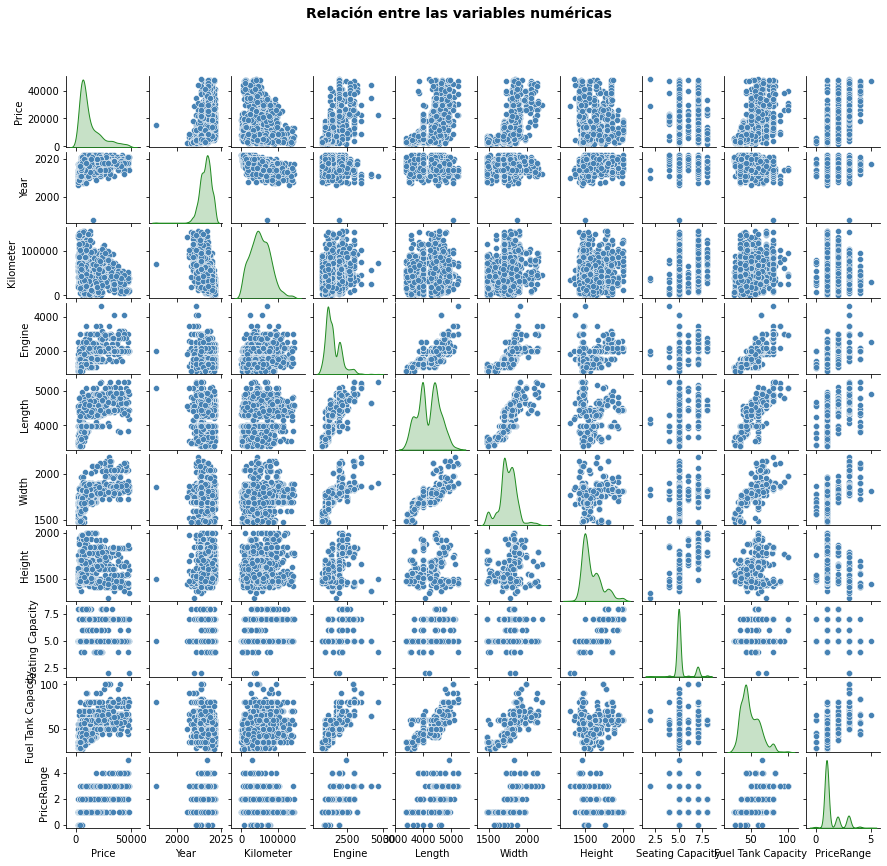

In [11]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [12]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('Price') 

### Variable de salida

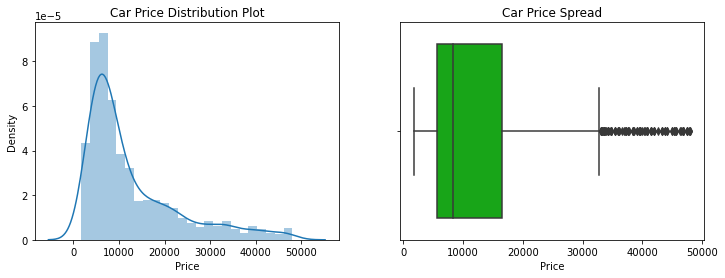

In [13]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.Price, palette='nipy_spectral')

plt.show()

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count    1441
mean    12601
std     10255
min      1740
25%      5580
50%      8388
75%     16500
85%     22500
90%     28800
95%     35880
97.5%   41400
100%    48000
max     48000
Name: Price, dtype: float64


## 5. Preparación de datos

### Creación de Variables Dummies

In [15]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

In [16]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1441 non-null   float64
 1   Year                    1441 non-null   float64
 2   Kilometer               1441 non-null   float64
 3   Engine                  1441 non-null   float64
 4   Length                  1441 non-null   float64
 5   Width                   1441 non-null   float64
 6   Height                  1441 non-null   float64
 7   Seating Capacity        1441 non-null   float64
 8   Fuel Tank Capacity      1441 non-null   float64
 9   PriceRange              1441 non-null   int64  
 10  Fuel Type_Otro          1441 non-null   uint8  
 11  Fuel Type_Petrol        1441 non-null   uint8  
 12  Transmission_Manual     1441 non-null   uint8  
 13  Owner_Fourth            1441 non-null   uint8  
 14  Owner_Second            1441 non-null   

## 6. Creación del modelo

### Dividir el conjunto de datos

In [17]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns = "Price")
y = d['Price']

In [18]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Escalar Variables

**No es necesario escalar las variables** en los árboles de decisión ya que este tipo de modelo no se ve afectado por la escala de las variables. Además, los árboles de decisión no usan cálculos basados en distancias, por lo que la escala de las variables no afecta la estructura del árbol.

In [19]:
X_train.head()

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange,Fuel Type_Otro,Fuel Type_Petrol,Transmission_Manual,Owner_Fourth,Owner_Second,Owner_Third,Owner_UnRegistered Car,Seller Type_Corporate,Seller Type_Individual,Drivetrain_FWD,Drivetrain_RWD
99,2016,64000,1186,3765,1660,1520,5,43,1,0,0,1,0,1,0,0,0,1,1,0
1251,2016,53000,1197,3995,1745,1500,5,37,1,0,1,1,0,0,0,0,0,1,1,0
202,2017,45600,796,3395,1490,1475,5,35,1,0,1,1,0,0,0,0,0,1,1,0
1418,2014,80000,2143,4686,1810,1442,5,66,3,0,0,0,0,0,0,0,0,1,0,1
254,2022,9000,1493,4300,1790,1635,5,50,1,0,0,1,0,0,0,0,0,1,1,0


In [20]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'PriceRange']


In [21]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
99,0.8235,0.4393,0.1016,0.1992,0.2613,0.3195,0.5000,0.2192,0.2000
1251,0.8235,0.3630,0.1044,0.3231,0.3814,0.2908,0.5000,0.1370,0.2000


### Creación del modelo

**Parámetros importantes** 


- **criterion** {‘squared_error’, ‘friedman_mse’, ‘absolute_error’, ‘poisson’}, default=‘squared_error’ 
Función para medir la calidad de la división utlizando el criterio definido como parametro ‘squared_error’, ‘friedman_mse’, ‘absolute_error’ o ‘poisson’


- **max_depth** {int, default=None}: Profundidad máxima del árbol. Si se establece en None, se expanden todos los nodos hasta que todas las hojas contengan menos de min_samples_split muestras.


- **min_samples_split** {int or float, default=2}: número mínimo de muestras requeridas para dividir un nodo interno.


- **min_samples_leaf** {int or float, default=1}: número mínimo de muestras requeridas en cada hoja.


- **max_features** {int, float or {“auto”, “sqrt”, “log2”}, default=None}: número máximo de características a considerar cuando se busca la mejor división.

In [22]:
# Creación del modelo
# ------------------------------------------------------------------------------
dTreeR = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
dTreeR.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=123)

In [23]:
print('Training:', dTreeR.score(X_train,y_train)) 
print('Test    :',r2_score(y_test,dTreeR.predict(X_test)))

Training: 0.7389828923191204
Test    : 0.7308235945946215


Profundidad del árbol: 3
Número de nodos terminales: 8


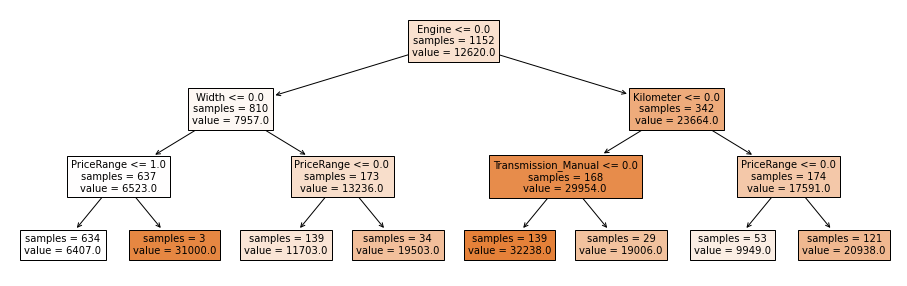

In [24]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 5))

print(f"Profundidad del árbol: {dTreeR.get_depth()}")
print(f"Número de nodos terminales: {dTreeR.get_n_leaves()}")

plot = plot_tree(
            decision_tree = dTreeR,
            feature_names = d.drop(columns = "Price").columns,
            class_names   = 'Price',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 0,
            ax            = ax
       )

https://www.cienciadedatos.net/documentos/py07_arboles_decision_python.html

## 7. Afinando el modelo (tuning)

### Preparacion de datos

In [25]:
#Se reasigna los datos de entrada 'X' y salida 'y'
X = d.drop(columns = "Price")
y = d['Price']

#Nuevamente se asigna a 'X_Completo' y 'y_Completo' los datos entrada y salida respectivamente
X_Completo = X
y_Completo = y

In [26]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head(2)

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,0.9706,0.0582,0.1049,0.3220,0.2853,0.3367,0.5000,0.1096,0.2000
1,0.7647,0.6818,0.3633,0.6974,0.5720,0.5630,0.8333,0.5068,0.2000


### Identificando los mejores hiperparámetros

In [27]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor

#Se crea una instancia de una DecisionTreeRegressor 
modelTreeR = DecisionTreeRegressor()

CV = 10

#Se establecen los hiperparámetros
parameters = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [15, 30, 45, 60],
              'min_samples_leaf' : [15, 30, 45, 60],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los 
#hierparametros establecidos anteriormente
grid_TreeR = GridSearchCV(
                          modelTreeR, 
                          param_grid=parameters, 
                          cv=CV, 
                          verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_TreeR.fit(X_Completo,y_Completo) 

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV 1/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.560 total time=   0.0s
[CV 2/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.624 total time=   0.0s
[CV 3/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.500 total time=   0.0s
[CV 4/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.695 total time=   0.0s
[CV 5/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.624 total time=   0.0s
[CV 6/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.597 total time=   0.0s
[CV 7/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.474 total time=   0.0s
[CV 8/10] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;

[CV 9/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=45;, score=0.651 total time=   0.0s
[CV 10/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=45;, score=0.700 total time=   0.0s
[CV 1/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.560 total time=   0.0s
[CV 2/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.624 total time=   0.0s
[CV 3/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.500 total time=   0.0s
[CV 4/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.695 total time=   0.0s
[CV 5/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.624 total time=   0.0s
[CV 6/10] END max_depth=2, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.597 total time=   0.0s
[CV 7/10] END max_depth=2, max_

[CV 1/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.560 total time=   0.0s
[CV 2/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.624 total time=   0.0s
[CV 3/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.500 total time=   0.0s
[CV 4/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.695 total time=   0.0s
[CV 5/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.624 total time=   0.0s
[CV 6/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.597 total time=   0.0s
[CV 7/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.474 total time=   0.0s
[CV 8/10] END max_depth=2, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.533 total time=   0.0s
[CV 9/10] END max_depth=2, max_f

[CV 6/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.452 total time=   0.0s
[CV 7/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.555 total time=   0.0s
[CV 8/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.504 total time=   0.0s
[CV 9/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.529 total time=   0.0s
[CV 10/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.622 total time=   0.0s
[CV 1/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.556 total time=   0.0s
[CV 2/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.443 total time=   0.0s
[CV 3/10] END max_depth=2, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.589 total time=   0.0s
[CV 4/10] END max_depth=2, max_

[CV 1/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.421 total time=   0.0s
[CV 2/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.484 total time=   0.0s
[CV 3/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.399 total time=   0.0s
[CV 4/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.546 total time=   0.0s
[CV 5/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.624 total time=   0.0s
[CV 6/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.573 total time=   0.0s
[CV 7/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.336 total time=   0.0s
[CV 8/10] END max_depth=2, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.539 total time=   0.0s
[CV 9/10] END max_depth=2, max_f

[CV 10/10] END max_depth=2, max_features=log2, min_samples_leaf=15, min_samples_split=60;, score=0.657 total time=   0.0s
[CV 1/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.634 total time=   0.0s
[CV 2/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.527 total time=   0.0s
[CV 3/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.454 total time=   0.0s
[CV 4/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.447 total time=   0.0s
[CV 5/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.576 total time=   0.0s
[CV 6/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.444 total time=   0.0s
[CV 7/10] END max_depth=2, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.510 total time=   0.0s
[CV 8/10] END max_depth=2, max_

[CV 4/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.476 total time=   0.0s
[CV 5/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.544 total time=   0.0s
[CV 6/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.453 total time=   0.0s
[CV 7/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.378 total time=   0.0s
[CV 8/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.538 total time=   0.0s
[CV 9/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.506 total time=   0.0s
[CV 10/10] END max_depth=2, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.572 total time=   0.0s
[CV 1/10] END max_depth=2, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.636 total time=   0.0s
[CV 2/10] END max_depth=2, max_

[CV 5/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=45;, score=0.726 total time=   0.0s
[CV 6/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=45;, score=0.793 total time=   0.0s
[CV 7/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=45;, score=0.557 total time=   0.0s
[CV 8/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=45;, score=0.784 total time=   0.0s
[CV 9/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=45;, score=0.802 total time=   0.0s
[CV 10/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=45;, score=0.829 total time=   0.0s
[CV 1/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.816 total time=   0.0s
[CV 2/10] END max_depth=4, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.760 total time=   0.0s
[CV 3/10] END max_depth=4, max_

[CV 8/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=30;, score=0.776 total time=   0.0s
[CV 9/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=30;, score=0.782 total time=   0.0s
[CV 10/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=30;, score=0.817 total time=   0.0s
[CV 1/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.712 total time=   0.0s
[CV 2/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.752 total time=   0.0s
[CV 3/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.755 total time=   0.0s
[CV 4/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.844 total time=   0.0s
[CV 5/10] END max_depth=4, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.750 total time=   0.0s
[CV 6/10] END max_depth=4, max_

[CV 10/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=15;, score=0.680 total time=   0.0s
[CV 1/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.755 total time=   0.0s
[CV 2/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.635 total time=   0.0s
[CV 3/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.672 total time=   0.0s
[CV 4/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.719 total time=   0.0s
[CV 5/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.688 total time=   0.0s
[CV 6/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.741 total time=   0.0s
[CV 7/10] END max_depth=4, max_features=sqrt, min_samples_leaf=15, min_samples_split=30;, score=0.629 total time=   0.0s
[CV 8/10] END max_depth=4, max_

[CV 8/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=15;, score=0.741 total time=   0.0s
[CV 9/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=15;, score=0.672 total time=   0.0s
[CV 10/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=15;, score=0.606 total time=   0.0s
[CV 1/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=30;, score=0.616 total time=   0.0s
[CV 2/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=30;, score=0.658 total time=   0.0s
[CV 3/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=30;, score=0.591 total time=   0.0s
[CV 4/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=30;, score=0.733 total time=   0.0s
[CV 5/10] END max_depth=4, max_features=sqrt, min_samples_leaf=45, min_samples_split=30;, score=0.594 total time=   0.0s
[CV 6/10] END max_depth=4, max_

[CV 2/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.635 total time=   0.0s
[CV 3/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.732 total time=   0.0s
[CV 4/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.665 total time=   0.0s
[CV 5/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.742 total time=   0.0s
[CV 6/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.698 total time=   0.0s
[CV 7/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.695 total time=   0.0s
[CV 8/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.680 total time=   0.0s
[CV 9/10] END max_depth=4, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.727 total time=   0.0s
[CV 10/10] END max_depth=4, max_

[CV 6/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.676 total time=   0.0s
[CV 7/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.608 total time=   0.0s
[CV 8/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.697 total time=   0.0s
[CV 9/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.586 total time=   0.0s
[CV 10/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.662 total time=   0.0s
[CV 1/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.702 total time=   0.0s
[CV 2/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.674 total time=   0.0s
[CV 3/10] END max_depth=4, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.693 total time=   0.0s
[CV 4/10] END max_depth=4, max_

[CV 10/10] END max_depth=4, max_features=log2, min_samples_leaf=60, min_samples_split=60;, score=0.691 total time=   0.0s
[CV 1/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.866 total time=   0.0s
[CV 2/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.837 total time=   0.0s
[CV 3/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.838 total time=   0.0s
[CV 4/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.857 total time=   0.0s
[CV 5/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.825 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.850 total time=   0.0s
[CV 7/10] END max_depth=6, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.695 total time=   0.0s
[CV 8/10] END max_depth=6, max_

[CV 5/10] END max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.828 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.821 total time=   0.0s
[CV 7/10] END max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.675 total time=   0.0s
[CV 8/10] END max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.837 total time=   0.0s
[CV 9/10] END max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.793 total time=   0.0s
[CV 10/10] END max_depth=6, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.866 total time=   0.0s
[CV 1/10] END max_depth=6, max_features=auto, min_samples_leaf=45, min_samples_split=15;, score=0.733 total time=   0.0s
[CV 2/10] END max_depth=6, max_features=auto, min_samples_leaf=45, min_samples_split=15;, score=0.758 total time=   0.0s
[CV 3/10] END max_depth=6, max_

[CV 1/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.654 total time=   0.0s
[CV 2/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.736 total time=   0.0s
[CV 3/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.641 total time=   0.0s
[CV 4/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.828 total time=   0.0s
[CV 5/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.742 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.774 total time=   0.0s
[CV 7/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.532 total time=   0.0s
[CV 8/10] END max_depth=6, max_features=auto, min_samples_leaf=60, min_samples_split=60;, score=0.703 total time=   0.0s
[CV 9/10] END max_depth=6, max_f

[CV 9/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.747 total time=   0.0s
[CV 10/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.743 total time=   0.0s
[CV 1/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.696 total time=   0.0s
[CV 2/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.706 total time=   0.0s
[CV 3/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.595 total time=   0.0s
[CV 4/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.732 total time=   0.0s
[CV 5/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.704 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=sqrt, min_samples_leaf=30, min_samples_split=45;, score=0.695 total time=   0.0s
[CV 7/10] END max_depth=6, max_

[CV 4/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.706 total time=   0.0s
[CV 5/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.588 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.665 total time=   0.0s
[CV 7/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.637 total time=   0.0s
[CV 8/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=-0.000 total time=   0.0s
[CV 9/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.644 total time=   0.0s
[CV 10/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.746 total time=   0.0s
[CV 1/10] END max_depth=6, max_features=sqrt, min_samples_leaf=60, min_samples_split=45;, score=0.603 total time=   0.0s
[CV 2/10] END max_depth=6, max

[CV 5/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.700 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.754 total time=   0.0s
[CV 7/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.658 total time=   0.0s
[CV 8/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.805 total time=   0.0s
[CV 9/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.724 total time=   0.0s
[CV 10/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.791 total time=   0.0s
[CV 1/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=30;, score=0.767 total time=   0.0s
[CV 2/10] END max_depth=6, max_features=log2, min_samples_leaf=30, min_samples_split=30;, score=0.659 total time=   0.0s
[CV 3/10] END max_depth=6, max_

[CV 2/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.594 total time=   0.0s
[CV 3/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.672 total time=   0.0s
[CV 4/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.658 total time=   0.0s
[CV 5/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.642 total time=   0.0s
[CV 6/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.548 total time=   0.0s
[CV 7/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.560 total time=   0.0s
[CV 8/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.753 total time=   0.0s
[CV 9/10] END max_depth=6, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.653 total time=   0.0s
[CV 10/10] END max_depth=6, max_

[CV 1/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.848 total time=   0.0s
[CV 2/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.829 total time=   0.0s
[CV 3/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.805 total time=   0.0s
[CV 4/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.846 total time=   0.0s
[CV 5/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.811 total time=   0.0s
[CV 6/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.824 total time=   0.0s
[CV 7/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.688 total time=   0.0s
[CV 8/10] END max_depth=8, max_features=auto, min_samples_leaf=15, min_samples_split=60;, score=0.850 total time=   0.0s
[CV 9/10] END max_depth=8, max_f

[CV 7/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.577 total time=   0.0s
[CV 8/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.822 total time=   0.0s
[CV 9/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.787 total time=   0.0s
[CV 10/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=45;, score=0.822 total time=   0.0s
[CV 1/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=60;, score=0.732 total time=   0.0s
[CV 2/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=60;, score=0.758 total time=   0.0s
[CV 3/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=60;, score=0.762 total time=   0.0s
[CV 4/10] END max_depth=8, max_features=auto, min_samples_leaf=45, min_samples_split=60;, score=0.845 total time=   0.0s
[CV 5/10] END max_depth=8, max_

[CV 8/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=45;, score=0.817 total time=   0.0s
[CV 9/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=45;, score=0.743 total time=   0.0s
[CV 10/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=45;, score=0.792 total time=   0.0s
[CV 1/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=60;, score=0.622 total time=   0.0s
[CV 2/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=60;, score=0.756 total time=   0.0s
[CV 3/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=60;, score=0.758 total time=   0.0s
[CV 4/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=60;, score=0.767 total time=   0.0s
[CV 5/10] END max_depth=8, max_features=sqrt, min_samples_leaf=15, min_samples_split=60;, score=0.748 total time=   0.0s
[CV 6/10] END max_depth=8, max_

[CV 8/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=45;, score=0.664 total time=   0.0s
[CV 9/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=45;, score=0.769 total time=   0.0s
[CV 10/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=45;, score=0.756 total time=   0.0s
[CV 1/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=60;, score=0.670 total time=   0.0s
[CV 2/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=60;, score=0.623 total time=   0.0s
[CV 3/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=60;, score=0.712 total time=   0.0s
[CV 4/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=60;, score=0.675 total time=   0.0s
[CV 5/10] END max_depth=8, max_features=sqrt, min_samples_leaf=45, min_samples_split=60;, score=0.669 total time=   0.0s
[CV 6/10] END max_depth=8, max_

[CV 10/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=30;, score=0.702 total time=   0.0s
[CV 1/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.754 total time=   0.0s
[CV 2/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.687 total time=   0.0s
[CV 3/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.703 total time=   0.0s
[CV 4/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.734 total time=   0.0s
[CV 5/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.743 total time=   0.0s
[CV 6/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.775 total time=   0.0s
[CV 7/10] END max_depth=8, max_features=log2, min_samples_leaf=15, min_samples_split=45;, score=0.693 total time=   0.0s
[CV 8/10] END max_depth=8, max_

[CV 8/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.631 total time=   0.0s
[CV 9/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.688 total time=   0.0s
[CV 10/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=15;, score=0.757 total time=   0.0s
[CV 1/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.761 total time=   0.0s
[CV 2/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.658 total time=   0.0s
[CV 3/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.715 total time=   0.0s
[CV 4/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.728 total time=   0.0s
[CV 5/10] END max_depth=8, max_features=log2, min_samples_leaf=45, min_samples_split=30;, score=0.692 total time=   0.0s
[CV 6/10] END max_depth=8, max_

[CV 9/10] END max_depth=8, max_features=log2, min_samples_leaf=60, min_samples_split=60;, score=0.726 total time=   0.0s
[CV 10/10] END max_depth=8, max_features=log2, min_samples_leaf=60, min_samples_split=60;, score=0.732 total time=   0.0s
[CV 1/10] END max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.872 total time=   0.0s
[CV 2/10] END max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.846 total time=   0.0s
[CV 3/10] END max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.842 total time=   0.0s
[CV 4/10] END max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.861 total time=   0.0s
[CV 5/10] END max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.835 total time=   0.0s
[CV 6/10] END max_depth=10, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.864 total time=   0.0s
[CV 7/10] END max_depth=1

[CV 7/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=45;, score=0.676 total time=   0.0s
[CV 8/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=45;, score=0.838 total time=   0.0s
[CV 9/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=45;, score=0.793 total time=   0.0s
[CV 10/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=45;, score=0.869 total time=   0.0s
[CV 1/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.848 total time=   0.0s
[CV 2/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.827 total time=   0.0s
[CV 3/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.804 total time=   0.0s
[CV 4/10] END max_depth=10, max_features=auto, min_samples_leaf=30, min_samples_split=60;, score=0.876 total time=   0.0s
[CV 5/10] END max_depth

[CV 5/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=30;, score=0.742 total time=   0.0s
[CV 6/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=30;, score=0.775 total time=   0.0s
[CV 7/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=30;, score=0.532 total time=   0.0s
[CV 8/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=30;, score=0.703 total time=   0.0s
[CV 9/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=30;, score=0.720 total time=   0.0s
[CV 10/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=30;, score=0.822 total time=   0.0s
[CV 1/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.654 total time=   0.0s
[CV 2/10] END max_depth=10, max_features=auto, min_samples_leaf=60, min_samples_split=45;, score=0.736 total time=   0.0s
[CV 3/10] END max_depth

[CV 2/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.617 total time=   0.0s
[CV 3/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.731 total time=   0.0s
[CV 4/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.759 total time=   0.0s
[CV 5/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.691 total time=   0.0s
[CV 6/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.677 total time=   0.0s
[CV 7/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.743 total time=   0.0s
[CV 8/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.746 total time=   0.0s
[CV 9/10] END max_depth=10, max_features=sqrt, min_samples_leaf=30, min_samples_split=30;, score=0.748 total time=   0.0s
[CV 10/10] END max_depth

[CV 9/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=15;, score=0.518 total time=   0.0s
[CV 10/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=15;, score=0.714 total time=   0.0s
[CV 1/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.451 total time=   0.0s
[CV 2/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.627 total time=   0.0s
[CV 3/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.687 total time=   0.0s
[CV 4/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.675 total time=   0.0s
[CV 5/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.662 total time=   0.0s
[CV 6/10] END max_depth=10, max_features=sqrt, min_samples_leaf=60, min_samples_split=30;, score=0.500 total time=   0.0s
[CV 7/10] END max_depth

[CV 1/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.320 total time=   0.0s
[CV 2/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.714 total time=   0.0s
[CV 3/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.631 total time=   0.0s
[CV 4/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.763 total time=   0.0s
[CV 5/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.768 total time=   0.0s
[CV 6/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.798 total time=   0.0s
[CV 7/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.540 total time=   0.0s
[CV 8/10] END max_depth=10, max_features=log2, min_samples_leaf=30, min_samples_split=15;, score=0.836 total time=   0.0s
[CV 9/10] END max_depth=

[CV 7/10] END max_depth=10, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.692 total time=   0.0s
[CV 8/10] END max_depth=10, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.702 total time=   0.0s
[CV 9/10] END max_depth=10, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.706 total time=   0.0s
[CV 10/10] END max_depth=10, max_features=log2, min_samples_leaf=45, min_samples_split=60;, score=0.797 total time=   0.0s
[CV 1/10] END max_depth=10, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.572 total time=   0.0s
[CV 2/10] END max_depth=10, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.567 total time=   0.0s
[CV 3/10] END max_depth=10, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.650 total time=   0.0s
[CV 4/10] END max_depth=10, max_features=log2, min_samples_leaf=60, min_samples_split=15;, score=0.708 total time=   0.0s
[CV 5/10] END max_depth

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [15, 30, 45, 60],
                         'min_samples_split': [15, 30, 45, 60]},
             verbose=3)

In [28]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_TreeR.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score
193,10,auto,15,30,0.8444,0.0464
192,10,auto,15,15,0.8444,0.0464
144,8,auto,15,15,0.8444,0.0465
145,8,auto,15,30,0.8444,0.0465


In [29]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_TreeR = pd.DataFrame(grid_TreeR.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_TreeR = ['param_max_depth']  + \
                    ['param_min_samples_split']  + \
                    ['param_min_samples_leaf']  + \
                    ['param_max_features']   + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_TreeR_filtered = results_grid_TreeR[columns_grid_TreeR]

# Crear la columna scoreWithStd: f1 / std
results_grid_TreeR_filtered['scoreWithStd'] = results_grid_TreeR_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_TreeR_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_TreeR_filtered[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf','param_max_features','mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score,std_test_score,scoreWithStd
0,2,15,15,auto,0.6029,0.0708,8.5159
1,2,30,15,auto,0.6029,0.0708,8.5159
2,2,45,15,auto,0.6029,0.0708,8.5159
3,2,60,15,auto,0.6029,0.0708,8.5159
4,2,15,30,auto,0.6029,0.0708,8.5159
...,...,...,...,...,...,...,...
235,10,60,45,log2,0.6975,0.0626,11.1387
236,10,15,60,log2,0.6395,0.0663,9.6510
237,10,30,60,log2,0.6611,0.0696,9.5038
238,10,45,60,log2,0.6549,0.0453,14.4549


In [30]:
# Se identifican los mejores hiperparámetros
best_params = grid_TreeR.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 15}


In [31]:
# Top 3 de los mejores scores
results_grid_TreeR_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf','param_max_features','mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score,std_test_score,scoreWithStd
117,6,30,30,sqrt,0.7196,0.0281,25.6425
68,4,15,30,sqrt,0.6472,0.0273,23.6855
216,10,15,45,sqrt,0.6753,0.0325,20.8008


In [32]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_TreeR_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth                 6
param_min_samples_split        30
param_min_samples_leaf         30
param_max_features           sqrt
mean_test_score            0.7196
std_test_score             0.0281
split0_test_score          0.7184
split1_test_score          0.6661
split2_test_score          0.7144
split3_test_score          0.6981
split4_test_score          0.7133
split5_test_score          0.7247
split6_test_score          0.7726
split7_test_score          0.6997
split8_test_score          0.7466
split9_test_score          0.7425
scoreWithStd              25.6425
Name: 117, dtype: object

In [33]:
results_grid_TreeR_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.7196443130219945

### Creación del modelo final

In [34]:
# Usar los mejores parámetros para crear el modelo
#modelTreeR.set_params(**best_params)

#modelTreeR.fit(X_Completo, y_Completo)

In [35]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros 
modelTreeR = DecisionTreeRegressor( max_depth = best_params["max_depth"]
                               , min_samples_split = best_params["min_samples_split"]
                               , min_samples_leaf = best_params["min_samples_leaf"]
                               , max_features = best_params["max_features"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelTreeR.fit(X_Completo, y_Completo)

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=15,
                      min_samples_split=15, random_state=1234)

In [36]:
# Se imprime el resultado que debe ser mejor que el inicial dado que se identificaron los mejores hiperparámetros

print(modelTreeR.score(X_Completo,y_Completo))

0.8894320228461016


### Utilizando *ccp_alpha*

In [37]:
#Se crea una instancia de una DecisionTreeRegressor 
modelTreeR_ccp = DecisionTreeRegressor( random_state = 123)


# Definir los parámetros para la búsqueda en la cuadrícula
parameters = {'ccp_alpha': np.logspace(-6, 2, 9)} # Valores entre 0.000001 y 100 en una escala logarítmica
#parameters = {'ccp_alpha': [0.000001]} # Valores entre 0.000001 y 100 en una escala logarítmica

# Definimos las metricas sobre las que queremos evaluar
metricas = 'f1'

# definicion de la variable con el número de pliegues
CV = 10

# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los 
#hierparametros establecidos anteriormente
grid_TreeR = GridSearchCV(
                          modelTreeR_ccp, 
                          param_grid=parameters, 
                          cv=CV, 
                          verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_TreeR.fit(X_Completo,y_Completo) 

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV 1/10] END ..................ccp_alpha=1e-06;, score=0.835 total time=   0.0s
[CV 2/10] END ..................ccp_alpha=1e-06;, score=0.875 total time=   0.0s
[CV 3/10] END ..................ccp_alpha=1e-06;, score=0.788 total time=   0.0s
[CV 4/10] END ..................ccp_alpha=1e-06;, score=0.902 total time=   0.0s
[CV 5/10] END ..................ccp_alpha=1e-06;, score=0.839 total time=   0.0s
[CV 6/10] END ..................ccp_alpha=1e-06;, score=0.826 total time=   0.0s
[CV 7/10] END ..................ccp_alpha=1e-06;, score=0.825 total time=   0.0s
[CV 8/10] END ..................ccp_alpha=1e-06;, score=0.909 total time=   0.0s
[CV 9/10] END ..................ccp_alpha=1e-06;, score=0.861 total time=   0.0s
[CV 10/10] END .................ccp_alpha=1e-06;, score=0.903 total time=   0.0s
[CV 1/10] END ..................ccp_alpha=1e-05;, score=0.835 total time=   0.0s
[CV 2/10] END ..................ccp_alpha=1e-05;

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'ccp_alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02])},
             verbose=3)

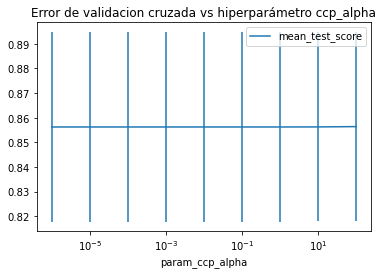

In [38]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid_TreeR.cv_results_)

# Variacion de ccp_alpha
ax.set_xscale('log')
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [39]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_TreeR.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_ccp_alpha,mean_test_score,std_test_score
8,100.0000,0.8564,0.0385
7,10.0000,0.8563,0.0384
5,0.1000,0.8562,0.0384
0,0.0000,0.8562,0.0384
1,0.0000,0.8562,0.0384
2,0.0001,0.8562,0.0384
3,0.0010,0.8562,0.0384
4,0.0100,0.8562,0.0384
6,1.0000,0.8562,0.0384


In [40]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid_TreeR.best_params_

{'ccp_alpha': 100.0}

In [41]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelTreeR_ccp = grid_TreeR.best_estimator_
print(f"Profundidad del árbol: {modelTreeR.get_depth()}")
print(f"Número de nodos terminales: {modelTreeR.get_n_leaves()}")
print(f"Score: {grid_TreeR.best_score_}")

Profundidad del árbol: 10
Número de nodos terminales: 71
Score: 0.8563812388903698


### Creación del modelo final

In [42]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelTreeR_ccp = DecisionTreeRegressor(
            ccp_alpha         = grid_TreeR.best_params_["ccp_alpha"],
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelTreeR_ccp.fit(X_Completo, y_Completo)

DecisionTreeRegressor(ccp_alpha=100.0, random_state=123)

### Guardar modelo

In [43]:
#Se guardan los modelos de árboles

joblib.dump(modelTreeR, './modelos/regresion/DTreeR_CV.pkl')
joblib.dump(modelTreeR_ccp, './modelos/regresion/DTreeR_CV_ccp.pkl')

['./modelos/regresion/DTreeR_CV_ccp.pkl']

#### Referencias

 
- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180





- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html